# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

### Code

### Import python libraries which are needed in this case

In [6]:
import numpy as np
import pandas as pd

!pip install opencage

from opencage.geocoder import OpenCageGeocode

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') 

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

import requests

from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.3.0
Libraries imported


### After reading from the Dataset, we found that the "Vancouver Crimes from 2003 to 2019" mentioned before contains to many data (about 600,000 rows) to process, so we still chosses the recent crime report of the 2018.

In [7]:
vnc_crime_df = pd.read_csv('https://raw.githubusercontent.com/RamanujaSVL/Coursera_Capstone/master/vancouver_crime_records_2018.csv', index_col=None)

vnc_crime_df.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


### Change the name of columns

In [8]:
vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vnc_crime_df.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


### Count the number of crimes in different neighborhoods

In [9]:
vnc_crime_df['Neighbourhood'].value_counts()

Central Business District    10857
West End                      3031
Mount Pleasant                2396
Strathcona                    1987
Kitsilano                     1802
Fairview                      1795
Renfrew-Collingwood           1762
Grandview-Woodland            1761
Kensington-Cedar Cottage      1391
Hastings-Sunrise              1270
Sunset                         967
Riley Park                     866
Marpole                        828
Victoria-Fraserview            600
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    414
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   292
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

### Gather additional information about the Neighborhood from Wikipedia：
[Wikipedia page](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver).

In [10]:
column_names = ['Neighbourhood', 'Borough'] 

vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


### Merge crime data and boroughs

In [11]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')

vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,Central
1,Break and Enter Commercial,2018,6,16,18,West End,Central
2,Break and Enter Commercial,2018,12,12,0,West End,Central
3,Break and Enter Commercial,2018,3,2,3,West End,Central
4,Break and Enter Commercial,2018,3,17,11,West End,Central


### Clean data furthermore

In [12]:
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

### Show the datailes of crime data to make a new table

In [13]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

### Merge the pivoted column with other columns

In [14]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


### Pivot the table to better understand the data by crimes per neighborhood

In [15]:
vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                     12   
Central Business District                        551   
Dunbar-Southlands                                  8   
Fairview                                         138   
Grandview-Woodland                               148   
Hastings-Sunrise                                  48   
Kensington-Cedar Cottage                          62   
Kerrisdale                                        24   
Killarney                                         34   
Kitsilano                                        106   
Marpole                                           44   
Mount Pleasant                                   205   
Musqueam                                           0   
Oakridge                                          19   
Renfrew-Collingwood                               91   
Riley Park                                        35   
Shaughnessy                                       12   
South Cambie                                      22   
Stanley Park                                       6   
Strathcona                                       160   
Sunset                                            37   
Victoria-Fraserview                               15   
West End                                         230   
West Point Grey                                   18   
All                                             2025   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            78       49   
Central Business District                               124     1812   
Dunbar-Southlands                                       106       81   
Fairview                                                 73      233   
Grandview-Woodland                                      162      304   
Hastings-Sunrise                                        117      195   
Kensington-Cedar Cottage                                145      255   
Kerrisdale                                               97       49   
Killarney                                                72       90   
Kitsilano                                               165      320   
Marpole                                                 125      134   
Mount Pleasant                                          124      353   
Musqueam                                                  4        3   
Oakridge                                                123       64   
Renfrew-Collingwood                                     156      243   
Riley Park                                              122      140   
Shaughnessy                                             120       41   
South Cambie                                             42       41   
Stanley Park                                              2        8   
Strathcona                                              124      527   
Sunset                                                   93      175   
Victoria-Fraserview                                      80       94   
West End                                                 72      460   
West Point Grey                                          71       50   
All                                                    2397     5721   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      18                111               12   
Central Business District        2034               5301              640   
Dunbar-Southlands                  31                199               16   


### Merge the pivoted Column with other columns trying to find what we need

In [16]:
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
2,Dunbar-Southlands,8,106,81,31,199,16,9,1,23,474
3,Fairview,138,73,233,297,692,245,55,0,62,1795
4,Grandview-Woodland,148,162,304,215,634,110,123,0,65,1761


### Use Pandas describe() to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values.

In [17]:
vnc_crime_cat.describe()

,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
count,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,506.250000,599.250000,1430.25000,1236.750000,3736.500000,539.750000,286.500000,3.250000,368.500000,8707.000000
std,354.409721,488.189427,997.26572,1060.087221,2723.536977,353.955153,226.117226,3.304038,227.060198,5801.870618
min,49.000000,156.000000,187.00000,88.000000,483.000000,36.000000,71.000000,1.000000,111.000000,1182.000000
25%,314.500000,187.500000,843.25000,544.000000,2249.250000,450.000000,186.500000,1.000000,263.250000,5698.500000
50%,594.500000,599.000000,1627.00000,1185.000000,3796.000000,633.000000,235.000000,2.000000,351.500000,9802.000000
75%,786.250000,1010.750000,2214.00000,1877.750000,5283.250000,722.750000,335.000000,4.250000,456.750000,12810.500000
max,787.000000,1043.000000,2280.00000,2489.000000,6871.000000,857.000000,605.000000,8.000000,660.000000,14042.000000


### Expolre the data by Visualising 

In [18]:
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
22,West End,230,72,460,455,1461,203,77,1,72,3031
11,Mount Pleasant,205,124,353,493,822,232,67,0,100,2396
19,Strathcona,160,124,527,81,821,108,76,2,88,1987
9,Kitsilano,106,165,320,154,755,189,51,1,61,1802


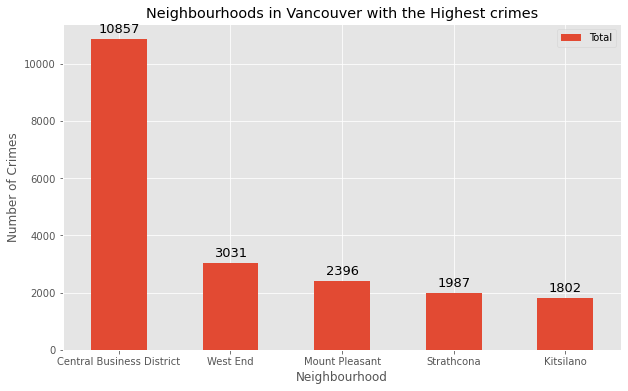

In [19]:
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 13,
               )

plt.show()

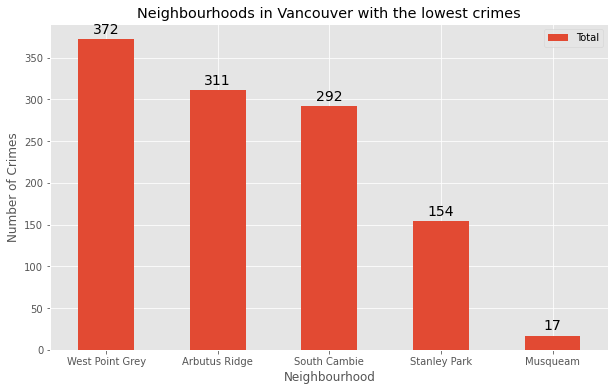

In [20]:
crime_neigh_low = vnc_crime_neigh.tail(5)
crime_neigh_low

per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [21]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


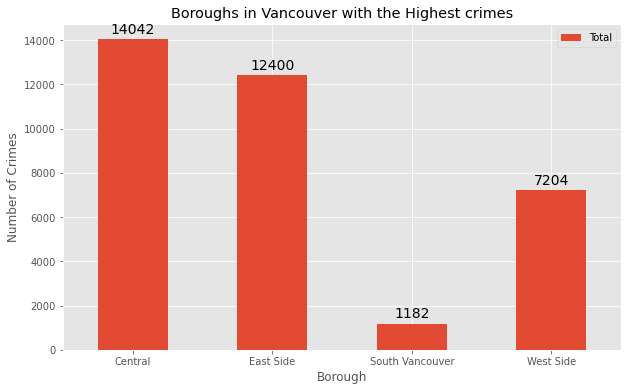

In [22]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

### Based on data analysis, it is clear that South Vancouver has the lowest crimes.But South Vancouver has very little number of neighborhoods, so it would make no profit by a convenience store. So we choose the next borough with lowest crime which is West Side.

### We take a look at the types of crimes in the West Side Borough,and find the Break and enter Commercial is low amongst other crimes types, which means it would be an ideal destination. 

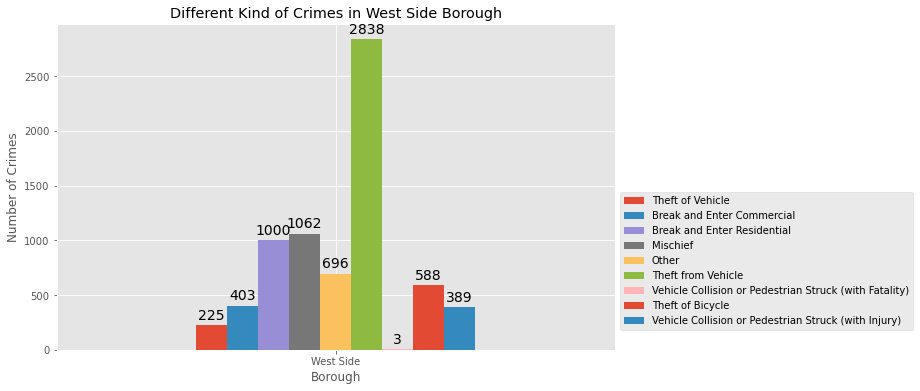

In [23]:
 vnc_ws_df = vnc_crime_cat[vnc_crime_cat['Borough'] == 'West Side']

 vnc_ws_df = vnc_ws_df.sort_values(['Total'], ascending = True, axis = 0)

vnc_ws = vnc_ws_df[['Borough','Theft of Vehicle', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle','Vehicle Collision or Pedestrian Struck (with Fatality)','Theft of Bicycle',
                 'Vehicle Collision or Pedestrian Struck (with Injury)']]


vnc_ws.set_index('Borough',inplace = True)

ax = vnc_ws.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in West Side Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

### Create a new dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighbourhood's co-ordinates.

In [24]:
vnc_ws_neigh = vnc_boroughs_crime

#vnc_ws_neigh.drop(['Type','Year', 'Month', 'Day', 'Hour'], axis = 1, inplace = True)
vnc_ws_neigh = vnc_ws_neigh[vnc_ws_neigh['Borough'] == 'West Side']
vnc_ws_neigh.reset_index(inplace=True, drop=True)

print('Number of Neighbourhoods in West Side Borough', len(vnc_ws_neigh['Neighbourhood'].unique()))

vnc_ws_neigh['Neighbourhood'].unique()

Number of Neighbourhoods in West Side Borough 10


array(['Shaughnessy', 'Fairview', 'Oakridge', 'Marpole', 'Kitsilano',
       'Kerrisdale', 'West Point Grey', 'Arbutus Ridge', 'South Cambie',
       'Dunbar-Southlands'], dtype=object)

### Create a new Data frame with Lat, Lng being fetched from OpenCage geocoder

In [25]:
Latitude = []
Longitude = []
Borough = []
Neighbourhood = vnc_ws_neigh['Neighbourhood'].unique()



key = '830323b5ca694362904814ff0a11b803'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('West Side')
print(Latitude, Longitude)

#print('The geograpical coordinate of Vancouver City are {}, {}.'.format(latitude, longitude))

[49.2518626, 49.2641128, 49.2308288, 49.2092233, 49.2694099, 49.2346728, 49.2644843, 49.2409677, 49.2466847, 49.2534601] [-123.1380226, -123.1268352, -123.1311342, -123.1361495, -123.155267, -123.1553893, -123.1854326, -123.1670008, -123.120915, -123.1850439]


In [26]:
ws_neig_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
ws_neig_geo = pd.DataFrame(data=ws_neig_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

ws_neig_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


### Fetching the Geographical co-ordiantes of Vancouver to plot on Map

In [27]:
address = 'Vancouver, BC, Canada'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of Vancouver, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver, Canada are 49.2608724, -123.1139529.


### Use Folium to plot Vancouver City's West Side Borough and it's Neighborhoods

In [28]:
van_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(ws_neig_geo['Latitude'], ws_neig_geo['Longitude'], ws_neig_geo['Borough'], ws_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(van_map)  
    
van_map

###  Create a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.
### This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

In [29]:
#Four Square Credentials

CLIENT_ID = 'XVY0YGK3DX5QGHMN2TGSK2EWA55P3JNPIVC5QVW5SGIGUI2L'
CLIENT_SECRET = 'T53Z3HT4W5DVALRIPBK2DPD4NFOCISMUTMNBLNW13KEJTAIJ'
VERSION = '20191101'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XVY0YGK3DX5QGHMN2TGSK2EWA55P3JNPIVC5QVW5SGIGUI2L
CLIENT_SECRET:T53Z3HT4W5DVALRIPBK2DPD4NFOCISMUTMNBLNW13KEJTAIJ


### Define a function to get top 10 venues around a given neighborhood

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

### Create a data frame containing venues for each neighborhood in West Side

In [31]:
vnc_ws_venues = getNearbyVenues(names=ws_neig_geo['Neighbourhood'],
                                   latitudes=ws_neig_geo['Latitude'],
                                   longitudes=ws_neig_geo['Longitude']
                                  )
print(vnc_ws_venues.shape)
vnc_ws_venues.head()

Shaughnessy
Fairview
Oakridge
Marpole
Kitsilano
Kerrisdale
West Point Grey
Arbutus Ridge
South Cambie
Dunbar-Southlands
(228, 5)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Shaughnessy,49.251863,-123.138023,Angus Park,Park
1,Shaughnessy,49.251863,-123.138023,Crepe & Cafe,French Restaurant
2,Fairview,49.264113,-123.126835,Gyu-Kaku Japanese BBQ,BBQ Joint
3,Fairview,49.264113,-123.126835,CRESCENT nail and spa,Nail Salon
4,Fairview,49.264113,-123.126835,Charleson Park,Park


### Venue count per neighborhood

In [32]:
vnc_ws_venues.groupby('Neighbourhood').count().drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Category'], axis = 1)

,Venue
Neighbourhood,
Arbutus Ridge,5
Dunbar-Southlands,6
Fairview,27
Kerrisdale,38
Kitsilano,49
Marpole,33
Oakridge,6
Shaughnessy,2
South Cambie,17


In [33]:
print('There are {} uniques categories.'.format(len(vnc_ws_venues['Venue Category'].unique())))

There are 90 uniques categories.


### Model word and one hot encoding to analyze each neighborhood

In [34]:
# one hot encoding
vnc_onehot = pd.get_dummies(vnc_ws_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vnc_onehot['Neighbourhood'] = vnc_ws_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [vnc_onehot.columns[-1]] + list(vnc_onehot.columns[:-1])
vnc_onehot = vnc_onehot[fixed_columns]

vnc_onehot.head()

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,...,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfall,Wine Shop,Yoga Studio
0,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Shaughnessy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fairview,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fairview,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
vnc_onehot.shape

(228, 91)

In [36]:
vnc_ws_grouped = vnc_onehot.groupby('Neighbourhood').mean().reset_index()
vnc_ws_grouped

,Neighbourhood,American Restaurant,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,...,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfall,Wine Shop,Yoga Studio
0,Arbutus Ridge,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Dunbar-Southlands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fairview,0.000000,0.000000,0.074074,0.037037,0.000000,0.037037,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000
3,Kerrisdale,0.000000,0.000000,0.026316,0.000000,0.026316,0.026316,0.000000,0.000000,0.000000,...,0.052632,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000
4,Kitsilano,0.040816,0.000000,0.020408,0.000000,0.081633,0.000000,0.000000,0.020408,0.000000,...,0.020408,0.020408,0.040816,0.000000,0.020408,0.000000,0.000000,0.000000,0.020408,0.020408
5,Marpole,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,...,0.000000,0.000000,0.030303,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.000000
6,Oakridge,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000
7,Shaughnessy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,South Cambie,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000
9,West Point Grey,0.000000,0.022222,0.022222,0.000000,0.022222,0.022222,0.022222,0.000000,0.044444,...,0.000000,0.000000,0.000000,0.022222,0.044444,0.000000,0.000000,0.000000,0.022222,0.022222


In [37]:
vnc_ws_grouped.shape

(10, 91)

### Top 5 most common venues across neighborhoods

In [38]:
num_top_venues = 5

for hood in vnc_ws_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = vnc_ws_grouped[vnc_ws_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
            venue  freq
0          Bakery   0.2
1  Nightlife Spot   0.2
2             Spa   0.2
3   Grocery Store   0.2
4       Pet Store   0.2


----Dunbar-Southlands----
                 venue  freq
0     Sushi Restaurant  0.33
1          Coffee Shop  0.17
2   Italian Restaurant  0.17
3       Ice Cream Shop  0.17
4  Sporting Goods Shop  0.17


----Fairview----
                 venue  freq
0          Coffee Shop  0.15
1     Asian Restaurant  0.07
2                 Park  0.07
3     Sushi Restaurant  0.04
4  Szechuan Restaurant  0.04


----Kerrisdale----
                venue  freq
0         Coffee Shop  0.11
1  Chinese Restaurant  0.08
2            Pharmacy  0.05
3    Sushi Restaurant  0.05
4      Sandwich Place  0.05


----Kitsilano----
                 venue  freq
0               Bakery  0.08
1           Food Truck  0.06
2  American Restaurant  0.04
3     Sushi Restaurant  0.04
4       Ice Cream Shop  0.04


----Marpole----
                venue  freq
0    Sushi

### Create the new dataframe and display the top 10 venues for each neighborhood.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = vnc_ws_grouped['Neighbourhood']

for ind in np.arange(vnc_ws_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vnc_ws_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Spa,Bakery,Grocery Store,Pet Store,Nightlife Spot,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant
1,Dunbar-Southlands,Sushi Restaurant,Ice Cream Shop,Sporting Goods Shop,Coffee Shop,Italian Restaurant,Indian Restaurant,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega
2,Fairview,Coffee Shop,Park,Asian Restaurant,Korean Restaurant,Malay Restaurant,Chinese Restaurant,Camera Store,Restaurant,Nail Salon,Salon / Barbershop
3,Kerrisdale,Coffee Shop,Chinese Restaurant,Pharmacy,Sushi Restaurant,Tea Room,Sandwich Place,Noodle House,Café,Portuguese Restaurant,Pizza Place
4,Kitsilano,Bakery,Food Truck,American Restaurant,Coffee Shop,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,French Restaurant,Thai Restaurant,Clothing Store


### Cluster Neighbourhoods

In [42]:
kclusters = 5

vnc_grouped_clustering = vnc_ws_grouped.drop('Neighbourhood', 1)

# k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vnc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 0, 0, 0, 0, 4, 1, 0, 0], dtype=int32)

In [43]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = ws_neig_geo

vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vancouver_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,West Side,49.251863,-123.138023,1,Park,French Restaurant,Coffee Shop,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant
1,Fairview,West Side,49.264113,-123.126835,0,Coffee Shop,Park,Asian Restaurant,Korean Restaurant,Malay Restaurant,Chinese Restaurant,Camera Store,Restaurant,Nail Salon,Salon / Barbershop
2,Oakridge,West Side,49.230829,-123.131134,4,Sushi Restaurant,Convenience Store,Vietnamese Restaurant,Café,Sandwich Place,Fast Food Restaurant,Food Truck,Cosmetics Shop,Deli / Bodega,Dessert Shop
3,Marpole,West Side,49.209223,-123.136150,0,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Pizza Place,Dessert Shop,Bus Stop,Bubble Tea Shop,Liquor Store,Noodle House,Plaza
4,Kitsilano,West Side,49.269410,-123.155267,0,Bakery,Food Truck,American Restaurant,Coffee Shop,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,French Restaurant,Thai Restaurant,Clothing Store


In [44]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Finally we need to examine the results

### Cluster 1

In [46]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Side,Coffee Shop,Park,Asian Restaurant,Korean Restaurant,Malay Restaurant,Chinese Restaurant,Camera Store,Restaurant,Nail Salon,Salon / Barbershop
3,West Side,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Pizza Place,Dessert Shop,Bus Stop,Bubble Tea Shop,Liquor Store,Noodle House,Plaza
4,West Side,Bakery,Food Truck,American Restaurant,Coffee Shop,Japanese Restaurant,Ice Cream Shop,Sushi Restaurant,French Restaurant,Thai Restaurant,Clothing Store
5,West Side,Coffee Shop,Chinese Restaurant,Pharmacy,Sushi Restaurant,Tea Room,Sandwich Place,Noodle House,Café,Portuguese Restaurant,Pizza Place
6,West Side,Café,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Bus Station,Pizza Place,Bookstore,Pub,Vegetarian / Vegan Restaurant,Fast Food Restaurant
8,West Side,Coffee Shop,Bus Stop,Juice Bar,Park,Vietnamese Restaurant,Cantonese Restaurant,Bank,Malay Restaurant,Grocery Store,Sushi Restaurant


### Cluster 2

In [47]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Side,Park,French Restaurant,Coffee Shop,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant


### Cluster 3

In [48]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 2, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,West Side,Sushi Restaurant,Ice Cream Shop,Sporting Goods Shop,Coffee Shop,Italian Restaurant,Indian Restaurant,Fast Food Restaurant,Convenience Store,Cosmetics Shop,Deli / Bodega


### Cluster 4

In [49]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,West Side,Spa,Bakery,Grocery Store,Pet Store,Nightlife Spot,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant


### Cluster 5

In [50]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 4, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,West Side,Sushi Restaurant,Convenience Store,Vietnamese Restaurant,Café,Sandwich Place,Fast Food Restaurant,Food Truck,Cosmetics Shop,Deli / Bodega,Dessert Shop


### Conclusion：After selecting the borough it was imperative to choose the right neighborhood where grocery shops were not among venues in a close proximity to each other. We achieved this by grouping the neighborhoods into clusters to assist the stakeholders by providing them with relavent data about venues and safety of a given neighborhood.